# 简单遗传算法实现
在这一篇中我们试图将各个操作组装起来，用进化算法解决一个简单的一元函数寻优问题。

## 问题描述与分析
给定一个函数 $h(x) = (x^2 + x)cos(2x)+x^2+x$，求解该函数的最大值。

该函数图像如下：

<img src="https://upload-images.jianshu.io/upload_images/17867674-263de2405aafbd33.jpg?imageMogr2/auto-orient/strip|imageView2/2/w/1200/format/webp" width="35%"/>

该函数的最大值应该出现在28.309042309042308处，值为1657.4235763265594。

可以看到该函数有很多局部极值作为干扰项，如果进化算法过早收敛，很容易陷入某个局部最优。

## 问题的编码与解码
对于该问题，可以选取很多不同的编码方式。本文计划采用二进制编码，精度要求到6位，那么首先应当确定编码的长度与解码方式。$x$给定定义域为$(-30,30)$，并且有：
$$2^{25}<60*10^6<2^{26}$$
所以我们需要的二进制编码长度为26。

## 利用DEAP自带算法求解
### DEAP自带的进化算法介绍
DEAP自带的算法都比较基础，通常可以用来测试问题描述、编码方式和交叉突变操作组合的有效性。需要比较复杂的进化算法时，可以通过在已经有的算子上进行扩充。

|算法|	描述
|---|---
|eaSimple|	简单进化算法
|eaMuPlusLambda|	$(\mu+\lambda)$进化算法
|eaMuCommaLambda|	$(\mu,\lambda)$进化算法

#### 简单进化算法 ：`deap.algorithms.eaSimple`

DEAP中预置的简单进化算法流程描述如下：

1. 根据工具箱中注册的`toolbox.evaluate`评价族群
1. 根据工具箱中注册的`toolbox.select`选择与父代相同个数的育种个体
1. 在族群中进行第一次循环，用工具箱中注册的`toolbox.mate`进行配种，并<u>用生成的两个子代替换对应父代</u>
1. 在族群中进行第二次循环，用工具箱中注册的`toolbox.mutate`进行变异，用<u>变异后的子代替换对应父代</u>
1. 从1开始重复循环，直到达到设定的迭代次数

需要注意的是在这个过程中，生成子代有四种情况：受到配种影响；受到变异影响；既受到配种也受到变异影响；既不受配种影响也不受变异影响。

对应的伪代码可以表述为：

```python
evaluate(population)
for g in range(ngen):
    population = select(population, len(population))
    offspring = varAnd(population, toolbox, cxpb, mutpb)
    evaluate(offspring)
    population = offspring
```

#### $(\mu+\lambda)$进化算法：`deap.algorithms.eaMuPlusLambda`
该算法的流程如下：

1. 根据工具箱中注册的`toolbox.evaluate`评价族群
1. 在族群中进行循环，在每次循环中，随机选择`crossover`，`mutation`和`reproduction`三者之一：如果选择到`crossover`，那么随机选择2个个体，用工具箱中注册的`toolbox.mate`进行配种，<u>将生成的第一个子代加入到后代列表中，第二个子代丢弃</u>；如果选择到`mutation`，用工具箱中注册的`toolbox.mutate`进行变异，<u>将变异后的子代加入到后代列表中</u>；如果选择到`reproduction`，随机选择一个个体，<u>将其复制加入到后代列表中</u>
1. 根据工具箱中注册的`toolbox.select`，在<u>父代+子代</u>中选择给定数量的个体作为子代
1. 从1开始重复循环，直到达到设定的迭代次数

注意在这个子代生成的过程中，子代不会同时受到变异和配种影响。

对应的伪代码可以表述为：

```python
evaluate(population)
for g in range(ngen):
    offspring = varOr(population, toolbox, lambda_, cxpb, mutpb)
    evaluate(offspring)
    population = select(population + offspring, mu)
```

#### $(\mu,\lambda)$进化算法：`deap.algorithms.eaMuCommaLambda`
与$(\mu+\lambda)$基本相同，唯一的区别在于生成子代族群时，只在产生的子代中选择，而丢弃所有父代。

对应的伪代码可以表述为：

```python
evaluate(population)
for g in range(ngen):
    offspring = varOr(population, toolbox, lambda_, cxpb, mutpb)
    evaluate(offspring)
    population = select(offspring, mu)
```


### 调用DEAP自带的进化算法
在调用DEAP自带的算法时需要注意的是，由于内置算法调用的alias已经提前给定，因此我们在register的时候，需要按照给定名称注册。

例如`toolbox.register('crossover', tools.cxUniform)`就不能被内置算法识别，而应当按照要求，命名为`mate`，并且显示给出交叉概率： `toolbox.register('mate', tools.cxUniform, indpb = 0.5)`

按照要求，使用预置的算法需要注册的工具有：

`toolbox.evaluate`：评价函数

`toolbox.select`：育种选择

`toolbox.mate`：交叉操作

`toolbox.mutate`：突变操作

### 代码与测试


In [4]:
from deap import algorithms, creator, tools, base
from scipy.stats import bernoulli

import random
import numpy as np

random.seed(42) #确保可以复现结果
# 描述问题
creator.create('FitnessMax', base.Fitness, weights=(1.0,)) # 单目标，最大值问题
creator.create('Individual', list, fitness = creator.FitnessMax) # 编码继承list类

# 个体编码
GENE_LENGTH = 26 # 需要26位编码

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5) #注册一个Binary的alias，指向scipy.stats中的bernoulli.rvs，概率为0.5
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = GENE_LENGTH) #用tools.initRepeat生成长度为GENE_LENGTH的Individual

# 评价函数
def decode(individual: creator.Individual) -> float:
    num = int(''.join([str(_) for _ in individual]), 2) # 解码到10进制
    x = -30 + num * 60 / (2**26 - 1) # 映射回-30，30区间
    return x

def eval(individual: creator.Individual) -> float:
    x = decode(individual)
    return ((np.square(x) + x) * np.cos(2*x) + np.square(x) + x),

# 生成初始族群
N_POP = 100 # 族群中的个体数量
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
pop = toolbox.population(n = N_POP)

# 在工具箱中注册遗传算法需要的工具
toolbox.register('evaluate', eval)
toolbox.register('select', tools.selTournament, tournsize = 2) # 注册Tournsize为2的锦标赛选择
toolbox.register('mate', tools.cxUniform, indpb = 0.5) # 注意这里的indpb需要显示给出
toolbox.register('mutate', tools.mutFlipBit, indpb = 0.5)

# 注册计算过程中需要记录的数据
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# 调用DEAP内置的算法
resultPop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=50, stats = stats, verbose = False)

# 输出计算过程
logbook.header = 'gen', 'nevals',"avg", "std", 'min', "max"
print(logbook)

C:\Users\airan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\airan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
gen	nevals	avg    	std    	min        	max    
0  	100   	312.114	371.579	-0.369935  	1420.83
1  	53    	468.302	442.969	-0.0257303 	1657.42
2  	59    	566.477	478.681	0.0587771  	1657.42
3  	52    	619.196	443.635	0.17213

In [5]:
"""
查看结果
"""

# 输出最优解
index = np.argmax([ind.fitness for ind in resultPop])
x = decode(resultPop[index]) # 解码
print('当前最优解：'+ str(x) + '\t对应的函数值为：' + str(resultPop[index].fitness))

当前最优解：28.308877919746607	对应的函数值为：(1657.4235317492396,)


### 结果可视化

Text(0, 0.5, 'Fitness')

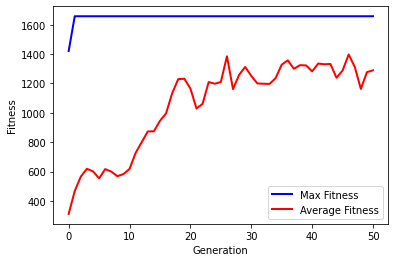

In [6]:
import matplotlib.pyplot as plt

gen = logbook.select('gen') # 用select方法从logbook中提取迭代次数
fit_maxs = logbook.select('max')
fit_average = logbook.select('avg')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(gen, fit_maxs, 'b-', linewidth = 2.0, label='Max Fitness')
ax.plot(gen, fit_average, 'r-', linewidth = 2.0, label='Average Fitness')
ax.legend(loc='best')
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness')

# fig.tight_layout()
# fig.savefig('Generation_Fitness.png')